In [175]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
%matplotlib inline

In [176]:
events = pd.read_pickle('out/41/events.pkl')
df = pd.read_pickle('out/21/donations.pkl')

In [177]:
events.head()

,appeal,campaign_location_id,campaign_month_id,transaction_count,amount,activity_year,activity_month,activity_ym,county,state
0,Banquet_GWOF,0,0,45,26548,2011,7,201107,Alameda,CA
1,Banquet_Gift Of Vision,0,0,46,9002,2010,10,201010,Alameda,CA
2,Banquet_Gujarat_CA_2008,0,0,16,8650,2008,7,200807,Santa Clara,CA
3,Banquet_Hyderabad,0,0,11,850,2015,10,201510,Santa Clara,CA
4,Banquet_Punjab_CA,0,0,65,15860,2009,11,200911,Alameda,CA


In [178]:
def month_diff(ym, number):
    '''
    example: month_diff(201505, 3) => 201502
    example: month_diff(201501, 3) => 201410
    '''
    y,m = int(ym/100), ym%100
    dy, dm = number/12, number%12
    m -= dm
    if m < 1:
        y, m = (y - 1), 12 + m
    return ((y - dy)*100) + m


In [179]:
def get_past_event_stats(state, year, month, prior_months_list):
    '''
    For a given list of numbers, go back that many months prior from the given month and get the event summary
    ex: state = CA, year = 2015, month = 1, prior_months_list = [1, 3, 6, 12, 18]
    Going back 1, 3, 6, 12 and 18 months from Jan 2012, return the summary stats (amount, attendance) for each duration
    get_past_event_stats('WA', 2013, 12, [1, 3, 6, 12])
    '''
    target_ym = year*100 + month
    stats = (state, year, month,)
    for prior_month in prior_months_list:
        subdata = events[(events.state==state)
               & (events.activity_ym > month_diff(target_ym, prior_month))
               & (events.activity_ym <= target_ym)]
        stats = stats + (subdata.amount.sum(),)
        stats = stats + (subdata.transaction_count.sum(),)
    return stats

## Setup response variables

In [180]:
response_stats = []
for state in df.state.unique():
    for year in range(2005, 2016):
        for month in range(1, 13):
            subdata = df[(df.is_service==False) & (df.state==state)
                         & (df.activity_year==year) & (df.activity_month==month)]
            response_stats.append((state, year, month, subdata.amount.sum(), subdata.donor_id.nunique()))

In [181]:
data_Y = pd.DataFrame(response_stats, columns=['state','year','month','amount','donor_count'])

## Setup predictor variables

In [182]:
cols = ['Amount (1 month)',
        'Attendance(1 month)',
        'Amount (3 months)',
        'Attendance(3 months)',
        'Amount (6 months)',
        'Attendance(6 months)',
        'Amount (12 months)',
        'Attendance(12 months)',
        'Amount (18 months)',
        'Attendance(18 months)',
        'Amount (24 months)',
        'Attendance(24 months)',
        'Amount (30 months)',
        'Attendance(30 months)']
xcols = ['state', 'year', 'month',]
xcols.extend(cols)

In [183]:
predictor_stats = data_Y.apply(lambda row: get_past_event_stats(row['state'], row['year'], row['month'], [1, 3, 6, 12, 18, 24, 30]), axis=1)

In [184]:
len(predictor_stats[0]), len(xcols)

(17, 17)

## Validate the data

In [189]:
events[(events.state=='WA') & (events.activity_year==2013)]

,appeal,campaign_location_id,campaign_month_id,transaction_count,amount,activity_year,activity_month,activity_ym,county,state
125,Event_ShreyaGhosal_WA,0,0,421,110934,2013,9,201309,King,WA
180,GivCam_WA_Food,0,0,12,335,2013,3,201303,King,WA
182,GivCampaign_Poker,0,1,28,3845,2013,3,201303,King,WA


In [190]:
get_past_event_stats('WA', 2013, 12, [1, 3, 6, 12])

('WA', 2013, 12, 0, 0, 0, 0, 110934L, 421L, 115114L, 461L)

In [191]:
df[(df.state=='WA') & (df.activity_year==2013)].groupby('activity_month').amount.sum()

activity_month
1      4246
2       910
3     85519
4      2826
5     43586
6      1955
7       731
8     45512
9     82688
10     9680
11    47178
12    15370
Name: amount, dtype: int64

In [192]:
data[(data.state=='WA') & (data.year==2013)]

,state,year,month,Amount (1 month),Attendance(1 month),Amount (3 months),Attendance(3 months),Amount (6 months),Attendance(6 months),Amount (12 months),Attendance(12 months),Amount (18 months),Attendance(18 months),Amount (24 months),Attendance(24 months),Amount (30 months),Attendance(30 months),amount,donor_count
1548,WA,2013,1,0,0,5054,41,5054,41,245659,776,245659,776,251074,815,255675,834,4246,17
1549,WA,2013,2,0,0,5054,41,5054,41,243599,755,245659,776,251074,815,255675,834,696,8
1550,WA,2013,3,4180,40,4180,40,9234,81,247779,795,249839,816,255254,855,259855,874,80551,309
1551,WA,2013,4,0,0,4180,40,9234,81,247779,795,249839,816,255254,855,259855,874,2728,17
1552,WA,2013,5,0,0,4180,40,9234,81,247779,795,249839,816,255254,855,255254,855,43336,193
1553,WA,2013,6,0,0,0,0,4180,40,9234,81,249839,816,255254,855,255254,855,1955,12
1554,WA,2013,7,0,0,0,0,4180,40,9234,81,249839,816,249839,816,255254,855,731,9
1555,WA,2013,8,0,0,0,0,4180,40,9234,81,247779,795,249839,816,255254,855,26868,131
1556,WA,2013,9,110934,421,110934,421,110934,421,120168,502,358713,1216,360773,1237,366188,1276,3857,17
1557,WA,2013,10,0,0,110934,421,110934,421,120168,502,358713,1216,360773,1237,366188,1276,8619,37


## Regression model

In [185]:
data_X = pd.DataFrame(predictor_stats.values.tolist(), columns=xcols)

### Exclude the data for the month of December since the organization gets
### heavy contributions in December which does not make the observations i.i.d.

data = data_X.merge(data_Y, on=['state','year','month'])
data = data[~(data.month==12)]
data = data[~(data.state=='CA')]

X = data[cols].values

In [186]:
k_fold = KFold(len(X), 3, shuffle=True, random_state=46)

In [187]:
# Predict the amount donated
y = data.donor_count.values

for k, (train, test) in enumerate(k_fold):
    rf = RandomForestRegressor()
    rf.fit(X[train], y[train])
    print rf.score(X[train], y[train])
print rf.score(X[test], y[test])

0.788410509987
0.826398302945
0.809782628016
0.493413414264


/home/msharath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


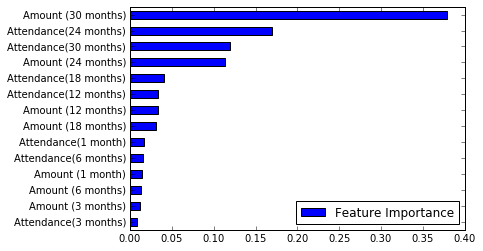

In [188]:
scores = pd.DataFrame({'Feature Importance' : rf.feature_importances_},
                           index=cols)
scores = scores.sort('Feature Importance')
scores.plot(kind='barh')

## Conclusion

As I add more bins (amount, donations for the last N months), the biggest of these intervals seems to be
the best predictor - which is really weird.

It appears as if the total amount given towards fund-raisers or number of attendees at the fund-raisers
in the past months is not a great model to use to predict the donations for that month. Dropping this exercise.
